In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['__MACOSX', 'plates', '__notebook_source__.ipynb', '.ipynb_checkpoints']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [3]:
# создаем dirty, clean в train, val
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        #if i % 5 != 0:
        dest_dir = os.path.join(train_dir, class_name)
        #else:
        #   dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5083.71it/s]


In [4]:
!ls train

cleaned  dirty


In [36]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

import albumentations as A
from albumentations.pytorch import ToTensor

train_augmentation = A.Compose(
    [
        A.CenterCrop(224, 224, p=0.7),
        A.HorizontalFlip(p=0.5),
        A.Transpose(),
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p=0.5
        ),
        A.ChannelShuffle(p=0.5),
        A.RGBShift(r_shift_limit=127, g_shift_limit=127, b_shift_limit=127, p = 0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)


val_augmentation = A.Compose(
    [
        A.CenterCrop(224, 224, p=0.5),
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Transpose(),
        A.CLAHE(p=1.),
        
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        
        ToTensor()
    ],
    p = 1
)


from torchvision import transforms, models

train_transforms = transforms.Compose([
    transforms.RandomChoice([transforms.CenterCrop(224), transforms.Resize((224,224))]),
    transforms.RandomApply([transforms.Grayscale(3)]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.RandomChoice([transforms.CenterCrop(224), transforms.Resize((224,224))]),
    transforms.RandomApply([transforms.Grayscale(3)]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# A generic data loader where the images are arranged in this way:
# torchvision.datasets.ImageFolder(root, transform=None, target_transform=None,
#                                  loader=<function default_loader>, is_valid_file=None)

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(train_dir, val_transforms)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [37]:
len(train_dataloader), len(train_dataset)

(4, 40)

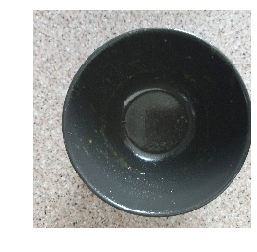

In [38]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.axis('off')
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

tensor(0)


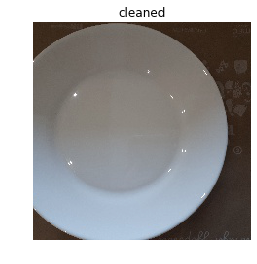

tensor(0)


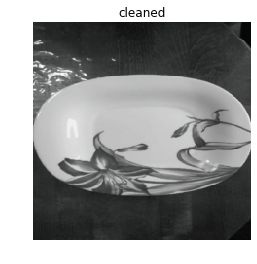

tensor(0)


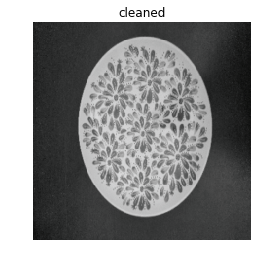

tensor(0)


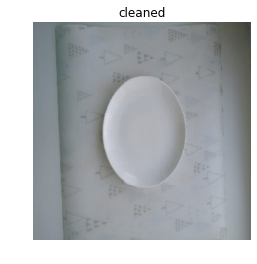

tensor(0)


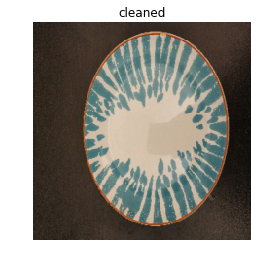

tensor(1)


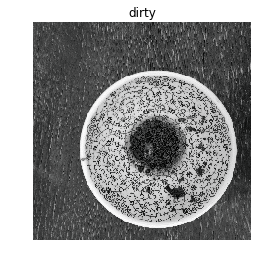

tensor(1)


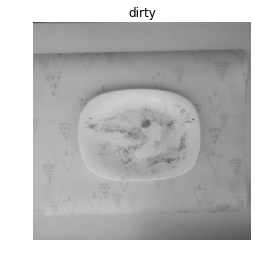

tensor(1)


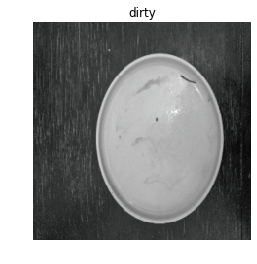

tensor(1)


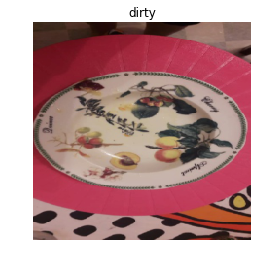

tensor(0)


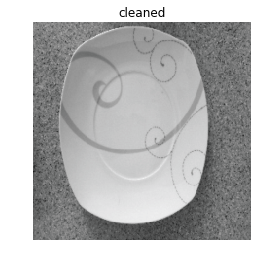

In [39]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    print(y_item)
    show_input(x_item, title=class_names[y_item])

In [42]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    loss_val_history = []
    loss_train_history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            if phase == 'train':
                loss_train_history.append(epoch_loss)
            else:
                loss_val_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return loss_train_history, loss_val_history

cuda:0
Epoch 0/99:
train Loss: 0.6903 Acc: 0.4750
val Loss: 0.6485 Acc: 0.7000
Epoch 1/99:
train Loss: 0.6485 Acc: 0.6500
val Loss: 0.6432 Acc: 0.5250
Epoch 2/99:
train Loss: 0.6118 Acc: 0.6000
val Loss: 0.5892 Acc: 0.6750
Epoch 3/99:
train Loss: 0.6300 Acc: 0.5750
val Loss: 0.5771 Acc: 0.5250
Epoch 4/99:
train Loss: 0.6902 Acc: 0.4750
val Loss: 0.5966 Acc: 0.5500
Epoch 5/99:
train Loss: 0.5717 Acc: 0.7000
val Loss: 0.5197 Acc: 0.8500
Epoch 6/99:
train Loss: 0.5700 Acc: 0.7750
val Loss: 0.5082 Acc: 0.9500
Epoch 7/99:
train Loss: 0.5136 Acc: 0.8750
val Loss: 0.5193 Acc: 0.9000
Epoch 8/99:
train Loss: 0.4921 Acc: 0.9500
val Loss: 0.4959 Acc: 0.9250
Epoch 9/99:
train Loss: 0.5497 Acc: 0.8500
val Loss: 0.5013 Acc: 0.9250
Epoch 10/99:
train Loss: 0.5287 Acc: 0.8250
val Loss: 0.5052 Acc: 0.9250
Epoch 11/99:
train Loss: 0.5109 Acc: 0.9250
val Loss: 0.5018 Acc: 0.9500
Epoch 12/99:
train Loss: 0.5691 Acc: 0.7750
val Loss: 0.4804 Acc: 0.9250
Epoch 13/99:
train Loss: 0.5203 Acc: 0.9500
val Loss: 

ValueError: x and y must have same first dimension, but have shapes (100,) and (2, 100)

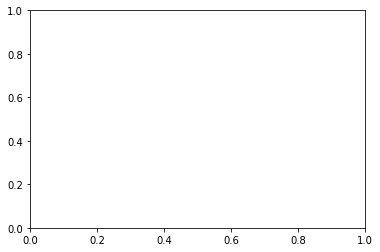

In [43]:
#resnet18 = models.resnet18(pretrained=True)
#resnet50 = models.resnet50(pretrained=True)
resnet152 = models.resnet152(pretrained=True)
#googlenet = models.googlenet(pretrained=True)
#ensemble = [resnet18, resnet50, googlenet, resnet152]
ensemble = [resnet152]

loss = torch.nn.CrossEntropyLoss()
num_epochs = 100

for model in ensemble:
    # Disable grad for all conv layers
    for name, param in model.named_parameters():
        param.requires_grad = False
        # batch normalization
        #if("bn" not in name):
        #    

    model.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features, 100),
                                   torch.nn.Linear(100, 2))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    # TRAIN
    loss_train_history = train_model(model, loss, optimizer, scheduler, num_epochs=num_epochs)
    # plot losses
    plt.plot(range(1,num_epochs + 1), *loss_train_history)#, loss_val_history)
    plt.legend(["train", "val"])
    plt.show()
    

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=batch_size)
# build csv
d = []
for inputs, labels in tqdm(train_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        row = [labels[0].cpu().data.numpy()]
        for model in ensemble:
            preds = model(inputs)
            proba = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()
            row.append(proba[0])
        d.append(tuple(row))
proba_nets_df = pd.DataFrame(d, columns=['label', 'resnet18','resnet52', 'resnet152', 'googlenet'])

In [ ]:
proba_nets_df.to_csv('proba_nets.csv')

In [ ]:
from sklearn import svm
# svm classifier

y = proba_nets_df['label'].astype(np.int8)
X = proba_nets_df.iloc[:, 1:]

svm_cl = svm.SVC()
svm_cl.fit(X,y)


In [44]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [45]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [46]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [49]:
for model in ensemble:
    model.eval()

test_predictions = []
test_img_paths = []

for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = ensemble[0](inputs)
        test_pred = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()
        #row = []
        for model in ensemble[1:]:
            pred = model(inputs)
            #proba = torch.nn.functional.softmax(pred, dim=1)[:,1].data.cpu().numpy()
            #row.append(proba[0])
    test_predictions.append(test_pred)    
    #test_predictions.append(svm_cl.predict(np.array(row)[np.newaxis,:]))
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 744/744 [00:20<00:00, 36.02it/s]


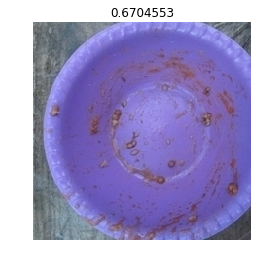

In [50]:
inputs, labels, paths = next(iter(test_dataloader))
for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [51]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [52]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,cleaned
0005,dirty


In [53]:
submission_df.to_csv('submission_2_layers_val.csv')

In [ ]:
!rm -rf test

In [ ]:
torch.save(ensemble[0].state_dict(), 'resnet152_2fc_layers')